# Libraries

In [ ]:
from bs4 import BeautifulSoup
import re
from hazm import Normalizer, word_tokenize
import numpy as np
import pandas as pd
import sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score
from matplotlib import pyplot as plt
from bidi.algorithm import get_display
import arabic_reshaper
from arabic_reshaper import reshape
import seaborn as sns
import nltk
import warnings
from nltk.corpus import stopwords
import string
from sklearn.preprocessing import LabelEncoder
from __future__ import unicode_literals
from hazm import word_tokenize
from wordcloud_fa import WordCloudFa
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
%pip install beautifulsoup4

# Load data

In [2]:
main_data = pd.read_csv('Data.csv', encoding='UTF-8')

In [3]:
main_data.isnull().sum()

category      0
title         1
abstract      1
body        936
time          1
dtype: int64

In [4]:
main_data = main_data.dropna()

In [5]:
main_data.isnull().sum()

category    0
title       0
abstract    0
body        0
time        0
dtype: int64

In [6]:
df = main_data.sample(n=2000, random_state=42)

In [7]:
df.isnull().sum()

category    0
title       0
abstract    0
body        0
time        0
dtype: int64

# A. Exploratory Analysis

The following function is written to fix the issue of flipped letters in Persian words in matplotlib charts.

In [8]:
def reshaper(text):
    return get_display(
        arabic_reshaper.reshape(
            u'%s' % str(text)
        )
    )

In [9]:
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['font.size'] = 14


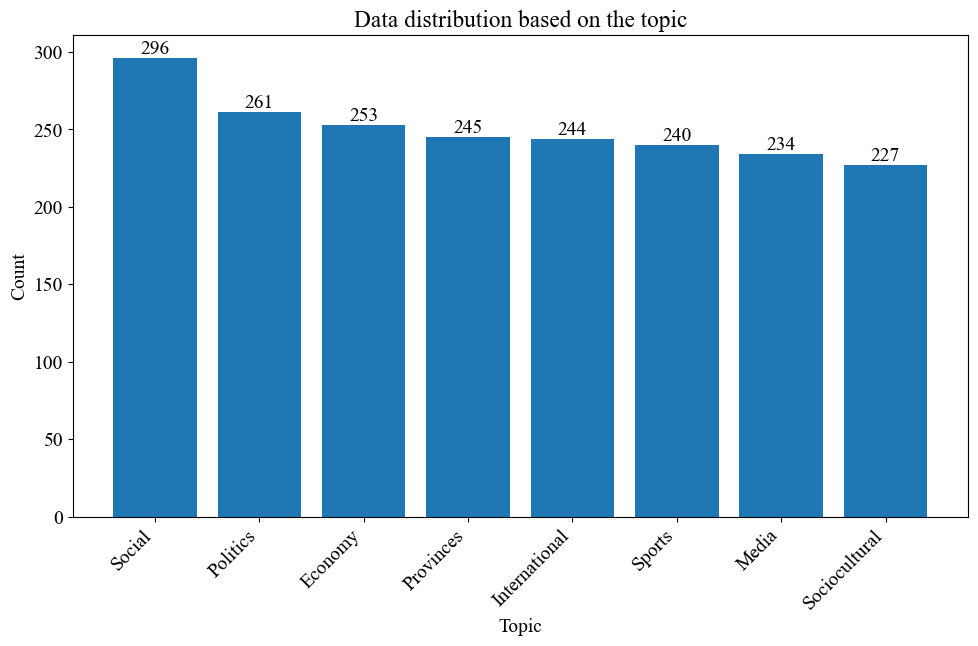

In [10]:
category_counts = df['category'].value_counts()
unique_categories = category_counts.index.tolist()
sorted_categories = sorted(
    unique_categories, key=lambda x: category_counts[x], reverse=True)

label_mapping = {
    'اجتماعی': 'Social',
    'سیاسی': 'Politics',
    'اقتصادی': 'Economy',
    'استان\u200cها': 'Provinces',
    'بین الملل': 'International',
    'ورزشی': 'Sports',
    'رسانه ها': 'Media',
    'فرهنگی هنری': 'Sociocultural'
}

reshaped_sorted_categories = [get_display(
    reshape(label_mapping[cat])) for cat in sorted_categories]

plt.figure(figsize=(10, 6))
plt.bar(reshaped_sorted_categories, category_counts[sorted_categories])
plt.xlabel(reshape('Topic'))
plt.ylabel(reshape('Count'))
plt.title(reshape('Data distribution based on the topic'))
for i, category in enumerate(sorted_categories):
    count = category_counts[category]
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=14)
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['font.size'] = 14
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()


In [11]:
df['body length'] = df['body'].apply(len)
max(df['body length'])

32269

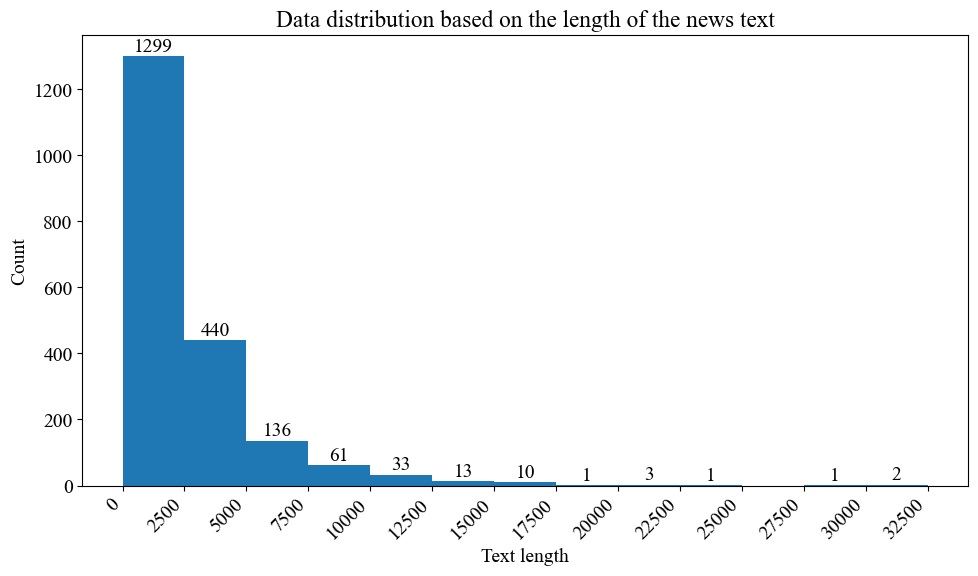

In [12]:
bins = [0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500]
plt.figure(figsize=(10, 6))
counts, _, _ = plt.hist(df['body length'], bins=bins)

for count, x, y in zip(counts, bins[:-1], counts):
    if count > 0:
        plt.text(x+1250, y+3, str(int(count)), ha='center', va='bottom')
        
plt.xlabel(reshaper('Text length'))
plt.ylabel(reshaper('Count'))
plt.title(reshaper('Data distribution based on the length of the news text'))
plt.xticks(bins, rotation='vertical')
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['font.size'] = 14
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

# B. Text Cleaning

In [13]:
# Cleaning and Preprocessing
columns_to_clean = ['title', 'abstract', 'body']

nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))

with open('stopwords.txt', encoding="utf-8") as f:
    persian_stopwords = f.read().splitlines()
etc = ['پیام', 'انتهای']
persian_stopwords.extend(etc)
persian_stopwords = pd.DataFrame(persian_stopwords, columns=['stopword'])

english_stopwords = pd.DataFrame(english_stopwords, columns=['stopword'])

all_stopwords = pd.concat([persian_stopwords, english_stopwords], axis=0)

english_punctuation_marks = string.punctuation
persian_punctuation_marks = ['،', '؛', '؟', '«', '»', '“', '”', '٬', '٫', '٪', '٭', 'ـ', ':', ',', '+', '/', '-', '(', ')', '[', ']', '{', '}', '؛']
persian_punctuation_marks = ''.join(str(x) for x in persian_punctuation_marks)
all_punctuation = english_punctuation_marks + persian_punctuation_marks

def text_process(text):

    normalizer = Normalizer()
    normalized_text = normalizer.normalize(text)
    
    soup = BeautifulSoup(normalized_text, features="html.parser")
    tag_cleaned_text = re.sub(r"\bhtml\b", "", str(soup))
    
    cleaned_text = tag_cleaned_text.translate(str.maketrans('', '', all_punctuation))

    for stopword in all_stopwords['stopword']:
        t = " " + stopword + " "
        cleaned_text = cleaned_text.replace(t, '  ')

    return cleaned_text

for column in columns_to_clean:
    df[column + ' new'] = df[column].apply(text_process)

# Merging 
df['merged'] = df['title new'] + df['abstract new'] + df['body new']

# Target
label_encoder = LabelEncoder()
target = df['category']
df['class'] = label_encoder.fit_transform(target)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mahan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# C. Vectorization

In [14]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf_vectorized = tfidf_vectorizer.fit_transform(df['merged'])
X_tfidf_vectorized.shape

(2000, 31722)

In [15]:
count_vectorizer = CountVectorizer()
X_count_vectorized = count_vectorizer.fit_transform(df['merged'])
X_count_vectorized.shape

(2000, 31722)

In [16]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
count_feature_names = count_vectorizer.get_feature_names_out()
print('TFIDF Feature Names: (Length = {0}) \n'.format(len(tfidf_feature_names)))
print('Count Feature Names: (Length = {0}) \n'.format(len(count_feature_names)))

TFIDF Feature Names: (Length = 31722) 

Count Feature Names: (Length = 31722) 



# E. Train and test split

In [17]:
tfidf_X = X_tfidf_vectorized
count_X = X_count_vectorized

y = df['class']
y.shape

(2000,)

In [18]:
tfidf_X_train, tfidf_X_test, y_train, y_test = train_test_split(tfidf_X, y, test_size=0.3, random_state=42)
count_X_train, count_X_test, y_train, y_test = train_test_split(count_X, y, test_size=0.3, random_state=42)

# F. Model Training

In [19]:
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['font.size'] = 14

In [20]:
models = {
    'Linear SVC': LinearSVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=500, solver='liblinear')}

vectorizers = ['TF-IDF', 'Count']

In [21]:
score_df = pd.DataFrame(index=models.keys(), columns=vectorizers)

accuracy_df = pd.DataFrame({'Model': list(models.keys())})

k = 5

train_accuracy = {}
test_accuracy = {}

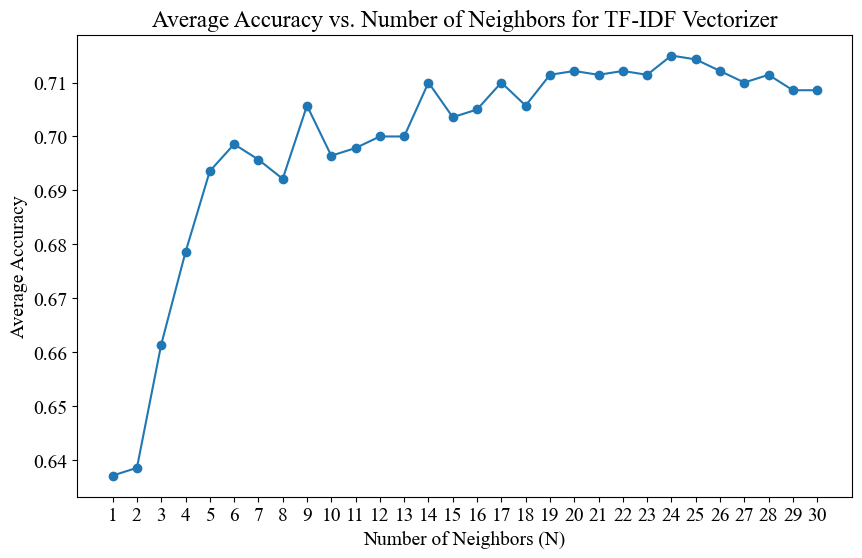

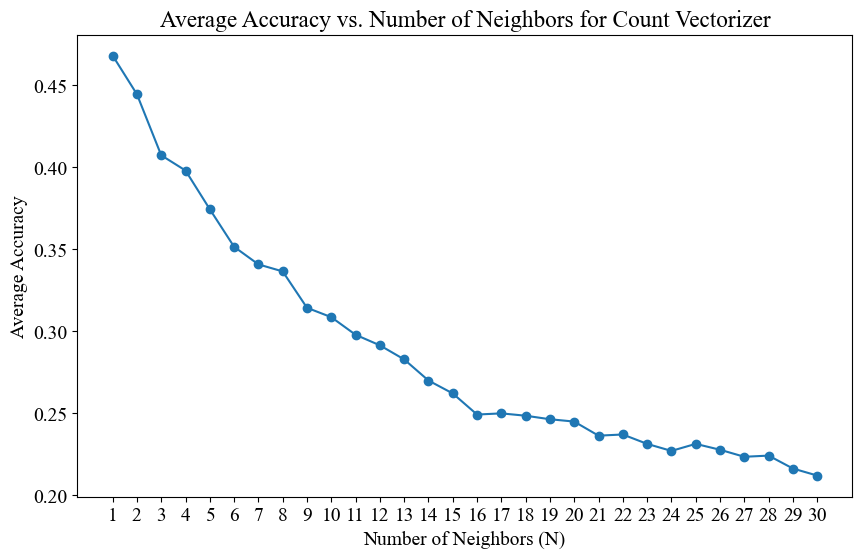

,TF-IDF,Count
Linear SVC,0.806429,0.789286
Decision Tree,0.717857,0.74
Random Forest,0.824286,0.825714
KNN,0.712143,0.465714
Logistic Regression,0.815714,0.824286


In [22]:
for model_name, model in models.items():
    
    train_accuracy[model_name] = []
    test_accuracy[model_name] = []

    for vectorizer_name in vectorizers:
        X_train = tfidf_X_train if vectorizer_name == 'TF-IDF' else count_X_train
        X_test = tfidf_X_test if vectorizer_name == 'TF-IDF' else count_X_test

        if model_name == 'KNN':
            param_grid = {'n_neighbors': np.arange(1,31)}
            grid_search = GridSearchCV(model, param_grid, cv=k)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_

            n_values = param_grid['n_neighbors']
            mean_scores = grid_search.cv_results_['mean_test_score']
            
            plt.figure(figsize=(10, 6))
            plt.plot(n_values, mean_scores, marker='o')
            plt.xlabel('Number of Neighbors (N)')
            plt.ylabel('Average Accuracy')
            plt.title('Average Accuracy vs. Number of Neighbors for ' + vectorizer_name + ' Vectorizer')
            plt.xticks(np.arange(1,31))
            plt.show()

        elif model_name == 'Logistic Regression':
            param_grid = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10]}
            grid_search = GridSearchCV(model, param_grid, cv=k)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
        else:
            model.fit(X_train, y_train)

        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        train_accuracy[model_name].append(train_acc)
        test_accuracy[model_name].append(test_acc)

        kfold = KFold(n_splits=k, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train, y_train, cv=kfold)

        avg_score = scores.mean()

        score_df.loc[model_name, vectorizer_name] = avg_score
score_df

<div dir="ltr" style="font-size:20px;">
<font face="Times New Roman">
<span style="font-weight: bold;">
Analysis of the results of the first section:
</div>

<div dir="ltr" style="font-size:18px; text-align: justify">
<font face="Times New Roman">

In this section, the measured metric is the average score of several criteria. Now, let's analyze the table.

**For the TF-IDF Vectorizer:**
- The Random Forest model has the highest score.
- In second and third place, the Logistic Regression and Linear SVC models respectively perform well.
- The Decision Tree and KNN models have not performed well.

**For the Count Vectorizer:**
- The Logistic Regression model has the highest score.
- In second and third place, the Random Forest and Linear SVC models have performed well and are close to the best model (Random Forest).
- The Decision Tree model has a lower score compared to the three previous models.
- Finally, the KNN model has the lowest performance.

Based on the available combinations and the current information, the best combination in terms of average scores overall is the Random Forest model with the TF-IDF vectorizer. Following this combination, the Logistic Regression with the Count vectorizer, and then the Random Forest with the Count vectorizer, with very little difference in the second and third positions, have also shown good performance.

The TF-IDF vectorizer has generally performed better in all models compared to the Count vectorizer. The TF-IDF vectorization assigns higher weights to rare words present in specific documents while downplaying common words. This weighting scheme helps models focus on important and distinctive features, potentially improving their ability to classify textual data accurately.

The following reasons could explain this performance difference:

- **Importance of rare words:** TF-IDF assigns higher weights to rare words that exist in specific documents. These rare words often help models distinguish more effectively between different classes.
- **Downplaying common words:** Common words that exist in multiple documents, such as pronouns and prepositions, receive lower weights in TF-IDF. This helps models concentrate on content-specific words that are more informative for classification.
- **Noise reduction:** TF-IDF can reduce the impact of noisy and uninformative words that may not significantly contribute to classification. By reducing the weight of these words, the vectorizer helps models focus on more meaningful and relevant aspects of the text.
</div>

<div dir="ltr" style="font-size:20px;">
<font face="Times New Roman">
<span style="font-weight: bold;">
Analysis of the average accuracy chart for various values of N in the KNN method
</div>

<div dir="ltr" style="font-size:18px; text-align: justify">
<font face="Times New Roman">

**1. KNN Model with TF-IDF Vectorizer:**
- It can be observed that as the value of N increases, the average accuracy of the KNN model with the TF-IDF vectorizer also tends to increase. The model reaches a relatively higher accuracy at around N=24 and then stabilizes with minor fluctuations.
- The TF-IDF vectorizer assigns higher weights to words that are important in a document but less common in the overall corpus. The goal of this approach is to capture the distinctive features of each document. As N increases, the KNN model considers a larger number of nearest neighbors for classification. This can lead to better generalization and improved accuracy because more relevant information from neighboring documents is taken into account. The increase in accuracy with increasing N indicates that a larger neighborhood context helps in making more accurate predictions.
- The oscillatory nature of the graph indicates that the choice of the number of neighbors significantly affects the model's performance. Changing N in the model results in different abilities to make accurate predictions on unseen data. The fluctuations and trends observed in the average scores can be attributed to the complexity of the dataset. In some cases, datasets with complex decision boundaries may require a more precise choice of N.

**2. KNN Model with Count Vectorizer:**
- Here, we observe a different behavior. As the value of N increases, the average accuracy of the model gradually decreases. The accuracy starts relatively high at N=1 but steadily decreases with increasing N.
- The Count vectorizer simply counts the frequency of each word in a document and does not consider the importance or rarity of words in the corpus. The decrease in accuracy with increasing N for the KNN model with the Count vectorizer can be attributed to dimensionality. As the number of neighbors considered increases, the feature space becomes smaller, and the relationships between the nearest neighbors may diminish. This can lead to reduced accuracy as the model becomes more susceptible to noise and less capable of good generalization.

In general, the difference in the behavior of the KNN model with the TF-IDF vectorizer and the Count vectorizer can be attributed to the distinct characteristics of the vectorization methods and their impact on capturing relevant information and managing high-dimensional feature spaces. Please note that these observations are specific to our dataset and may vary for different datasets.    
</div>

In [23]:
tfidf_train = []
tfidf_test = []
count_train = []
count_test =[]
for i in range(0, len(models.keys())):
    tfidf_train.append(list(train_accuracy.values())[i][0])
    tfidf_test.append(list(test_accuracy.values())[i][0])
    count_train.append(list(train_accuracy.values())[i][1])
    count_test.append(list(test_accuracy.values())[i][1])

accuracy_df['TF-IDF Train'] = tfidf_train
accuracy_df['TF-IDF Test'] = tfidf_test
accuracy_df['Count Train'] = count_train
accuracy_df['Count Test'] = count_test
accuracy_df

,Model,TF-IDF Train,TF-IDF Test,Count Train,Count Test
0,Linear SVC,1.000000,0.810000,1.0,0.768333
1,Decision Tree,1.000000,0.701667,1.0,0.748333
2,Random Forest,1.000000,0.816667,1.0,0.800000
3,KNN,0.740000,0.703333,1.0,0.455000
4,Logistic Regression,0.998571,0.788333,1.0,0.785000


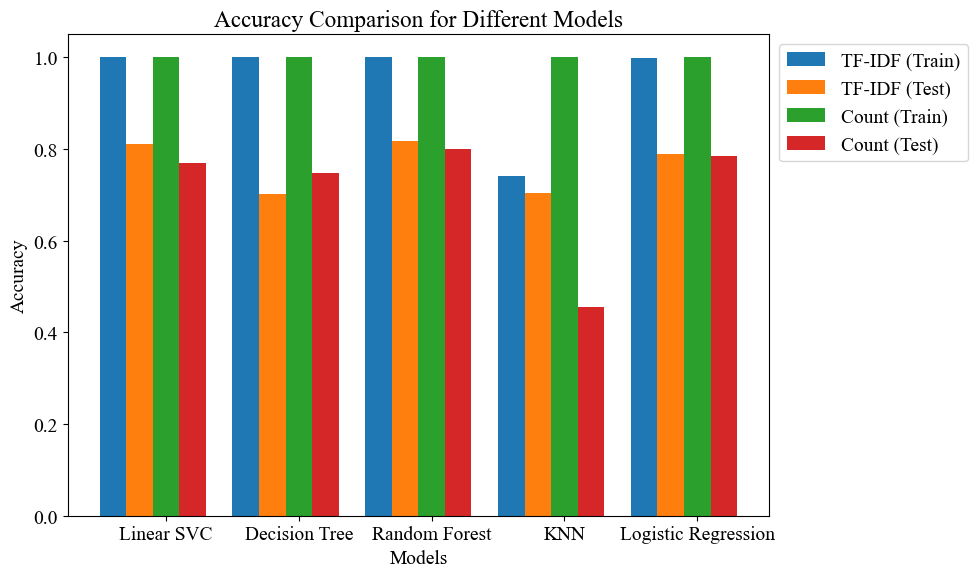

In [24]:
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(models))

train_data = accuracy_df[['TF-IDF Train', 'Count Train']].values.T
test_data = accuracy_df[['TF-IDF Test', 'Count Test']].values.T

plt.bar(index, train_data[0], bar_width, label='TF-IDF (Train)', alpha=1)
plt.bar(index + bar_width, test_data[0], bar_width, label='TF-IDF (Test)', alpha=1)
plt.bar(index + 2 * bar_width, train_data[1], bar_width, label='Count (Train)', alpha=1)
plt.bar(index + 3 * bar_width, test_data[1], bar_width, label='Count (Test)', alpha=1)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Different Models')
plt.xticks(index + 2 * bar_width, list(models.keys()))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

<div dir="ltr" style="font-size:20px;">
<font face="Times New Roman">
<span style="font-weight: bold;">
Analysis of the results for the second section
</div>

<div dir="ltr" style="font-size:18px; text-align: justify">
<font face="Times New Roman">

1. **Overfitting**: This occurs when a model becomes overly complex and captures noise or specific patterns in the training data that may not generalize well to new, unseen data. Consequently, the model may achieve a high accuracy on the training set but perform poorly on the test set, resulting in a noticeable difference in accuracy.
    - **TF-IDF Vectorizer**:
        - Training Accuracy: This model achieves a high accuracy on the training data because it learns patterns and specific features present in the training dataset. It can assign importance weights to words and closely match the training data.

        - Test Accuracy: The model's performance on the test data may be slightly lower due to overfitting. It could become highly specialized in capturing subtle nuances in the training data, making it less effective in generalizing to unseen data. It might struggle to handle variations and noise in the test data.
        
    - **Count Vectorizer**:
        - Training Accuracy: Similar to TF-IDF, this model achieves high accuracy by learning patterns and frequency-based features present in the training data. It perfectly matches the data based on word frequencies.
        
        - Test Accuracy: Test accuracy may also be slightly lower than training accuracy due to overfitting. This model might have learned specific word frequencies and combinations that are unique to the training data, making it less effective at generalizing to unseen data. It may struggle with handling semantic changes and domain differences in test data.

2. **Data Distribution Differences**: Training and test datasets may inherently differ in their distributions. If test data significantly differs from training data in terms of features, patterns, or fundamental characteristics, the model's performance can be adversely affected, leading to a gap between training and test accuracy.

3. **Limited Generalization**: Some models may struggle to generalize well to unseen data due to their complexity or inherent limitations. This can result in a gap between accuracy achieved on training data (where the model is more familiar) and accuracy on test data (representing new and unseen samples).

4. **Feature Selection**: Differences in accuracy can also result from feature engineering and selection processes. If the selected features do not adequately capture underlying patterns or if irrelevant features are included, the model's performance can be affected, leading to accuracy fluctuations.

5. **Hyperparameter Tuning**: Differences in accuracy can be attributed to changes in hyperparameter settings. Models may be tuned to perform well on the training data, resulting in high training accuracy. However, the same hyperparameters may not generalize optimally to the test set.

To mitigate these accuracy differences, techniques such as regularization, cross-validation, and increasing the size of the training dataset can be employed. Regularization methods like L1 or L2 in Logistic Regression can prevent overfitting by adding penalties to complex model parameters. Cross-validation provides a better estimate of model performance on unseen data. Increasing the training data can expose the model to a more diverse set of samples, aiding in better generalization.

**Criterion for Assessing Performance**

Consider the following criterion for assessing performance:

1. **Excellent Performance**: High accuracy in both test and training data.

2. **Good Performance**: High accuracy in either test or training data.

3. **Average Performance**: Moderate accuracy in both test and training data.

4. **Failure**: Low accuracy in both test and training data.

Now, with the defined criterion, we rank different combinations and determine the type of performance and the reasons for it.
1. Random Forest Model and TF-IDF Vectorizer: **Excellent**  
This combination has achieved high accuracy in both test and training data. The Random Forest model is an ensemble learning algorithm that can overcome the limitations of individual decision trees and combines multiple decision trees to make predictions for the combination. TF-IDF vectorization effectively represents the importance of words in the text, which helps Random Forest capture relevant features and achieve excellent performance.

2. Random Forest Model and Count Vectorizer: **Excellent**  
This model leverages its collective nature to handle complex patterns effectively. Additionally, the Count vectorizer, while not capturing word importance, still provides frequency information that can be valuable for the decision-making process of Random Forest.

3. Linear SVC Model and TF-IDF Vectorizer: **Excellent**  
The Linear SVC model is a linear classifier that aims to find the best hyperplane for data point separation and works well with high-dimensional data, making it suitable for text classification tasks. TF-IDF vectorization highlights word importance in documents and enables Linear SVC to utilize informative features effectively.

4. Logistic Regression Model and Count Vectorizer: **Good**  
The Logistic Regression model shows good performance with the Count vectorizer. This model is a popular classification algorithm that models the relationship between features and target classes. Although the Count vectorizer does not capture word importance, it can still be effective in using frequency information for classification.

5. Logistic Regression Model and TF-IDF Vectorizer: **Good**  
The Logistic Regression model, a linear classifier, works well with high-dimensional data. TF-IDF vectorization allows it to make effective use of important words for classification, resulting in good overall performance.

6. Decision Tree Model and TF-IDF Vectorizer: **Good**  
Despite its susceptibility to overfitting, especially with high-dimensional data, this combination has shown relatively good performance. The Decision Tree model is a non-parametric algorithm that creates a tree-like model for prediction. TF-IDF vectorization effectively highlights important features, aiding the Decision Tree in capturing relevant patterns and achieving good performance.

7. Decision Tree Model and Count Vectorizer: **Good**  
Similar to the previous combination, it has achieved a good accuracy score. The reason for the lower accuracy is that Decision Tree models may struggle with overfitting when using the Count vectorizer. The frequency-based representation may not capture word importance well enough, leading to slightly lower performance.

8. K-Nearest Neighbors (KNN) Model and TF-IDF Vectorizer: **Average**  
The KNN model is a distance-based algorithm relying on similarity between data points. TF-IDF vectorization may not be well-suited for KNN, as it primarily focuses on word importance rather than patterns of occurrence. KNN may attempt to find meaningful neighbors and achieve moderate performance. TF-IDF vectorization helps highlight important features, but KNN may not effectively capture complex patterns, resulting in average performance.

9. Linear SVC Model and Count Vectorizer: **Average**  
The primary goal of the Linear SVC algorithm is to find the best hyperplane for data point separation. However, the Count vectorizer may not provide efficient information like frequency and word importance to Linear SVC, which leads to average performance.

10. K-Nearest Neighbors (KNN) Model and Count Vectorizer: **Failure**  
This combination falls into the failure category due to its low accuracy in both test and training data. The KNN model may not perform well with the Count vectorizer, as the Count vectorization may not adequately capture relative word importance, leading to poor neighbor selection and lower performance.

**Note about Training Data Accuracy**  

The reason for the high accuracy of most training data (exactly 1) is that the training accuracy is calculated immediately after fitting the models to the training data. Since the models have seen and learned from the training data beforehand, they can accurately predict the training samples, resulting in high training accuracy. This behavior is expected and not necessarily indicative of overfitting.  However, it is important to emphasize that when evaluating model performance, the primary focus should be on test accuracy rather than training accuracy. Test accuracy measures the model's generalization to unseen data. Therefore, the emphasis should be on analyzing and interpreting test accuracy rather than training accuracy. If test accuracy consistently remains high across different models and vectorizers, it indicates that the models perform well on unseen data. On the other hand, if there is a significant drop in test accuracy compared to training accuracy, it may indicate a potential overfitting issue. Therefore, when considering the ranking, we only take into account test accuracy with the new criterion definition:

1. Random Forest Model and TF-IDF Vectorizer: **Excellent**

2. Random Forest Model and Count Vectorizer: **Excellent**

3. Linear SVC Model and TF-IDF Vectorizer: **Excellent**

4. Logistic Regression Model and TF-IDF Vectorizer: **Good**

5. Logistic Regression Model and Count Vectorizer: **Good**

6. Linear SVC Model and Count Vectorizer: **Good**

7. Decision Tree Model and Count Vectorizer: **Good**

8. K-Nearest Neighbors (KNN) Model and TF-IDF Vectorizer: **Good**

9. Decision Tree Model and TF-IDF Vectorizer: **Failure**

10. K-Nearest Neighbors (KNN) Model and Count Vectorizer: **Failure**

It is observed that due to the change in the criterion definition, the ranking has slightly changed from the previous evaluation. However, Random Forest models with either TF-IDF or Count vectorization are still the top-performing models in terms of accuracy.

</div>